<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [82]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

from datetime import datetime
from collections import deque
from itertools import islice

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'C:\\Users\\VyaznikovKS\\Desktop\\_уч\\PY_spec\\1_prepare_data\\capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [30]:
#тест-вариант для произвольного {сессия, окно}
def sliding_window(iterable_0, size_0, step_0, fillvalue_0):
    def sliding_generator(iterable, size=2, step=1, fillvalue=None):
        iterable = iterable + list(2 * step * [fillvalue])
        it = iter(iterable)
        q = deque(islice(it, size), maxlen=size)
        q.extend(fillvalue for _ in range(size - len(q)))
        while sum(q)>0:                                            
            yield iter(q)
            try:
                q.append(next(it))
            except StopIteration:
                return
            q.extend(next(it, fillvalue) for _ in range(step - 1))
        return
    l = []
    for i in sliding_generator(iterable_0, size_0, step_0, fillvalue_0):
        for j in i:
            l.append(j)
    return l

data = pd.DataFrame(columns=['timestamp', 'site', 'id'])
for name in glob(PATH_TO_DATA+'/3users/*.csv'):
    data_1 = pd.read_csv(name, sep=',')
    data_1['id'] = int(''.join([i for i in os.path.basename(name) if i.isdigit()]))   
    data = pd.concat([data, data_1])

data = data.reset_index(drop=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])

with open(os.path.join(PATH_TO_DATA,'site_freq_3users.pkl'), 'rb') as site_freq_pkl:
    site_freq = pickle.load(site_freq_pkl)

data_1 = data.copy(deep=True)
users = list(data.id.unique())

for i in range(data.shape[0]):
    if i < data.shape[0] - 1 and data.iloc[i,2] == data.iloc[i+1,2]:
        data_1.iloc[i,0] = int((data.iloc[i+1,0] - data.iloc[i,0]).total_seconds())
    else: data_1.iloc[i,0] = 0
    data_1.iloc[i,1] = site_freq[str(data.iloc[i,1])][0]

data_1['hour'] = data['timestamp'].apply(lambda x: x.hour)
data_1['day'] = data['timestamp'].apply(lambda x: x.dayofweek)    

data_group = data_1[['site', 'id']].groupby(by=['id']).count()           #считаем количество сайтов

n = []
l = list(data_group.index.unique())

for i in l:
    iterable_time = list(data_1[data_1.id == i].iloc[:,0])     #итератор - массив идшников сайтов для i-пользователя
    iterable_site = list(data_1[data_1.id == i].iloc[:,1])
    iterable_hour = list(data_1[data_1.id == i].iloc[:,3])
    iterable_wday = list(data_1[data_1.id == i].iloc[:,4])

    ins_time = sliding_window(iterable_0 = iterable_time, size_0 = 10, step_0 = 10, fillvalue_0 = 0)
    ins_site = sliding_window(iterable_0 = iterable_site, size_0 = 10, step_0 = 10, fillvalue_0 = 0)
    ins_hour = sliding_window(iterable_0 = iterable_hour, size_0 = 10, step_0 = 10, fillvalue_0 = 0)
    ins_wday = sliding_window(iterable_0 = iterable_wday, size_0 = 10, step_0 = 10, fillvalue_0 = 0)

    for time, site, hour, wday in zip(ins_time, ins_site, ins_hour, ins_wday):
        n.append([time, site, i, hour, wday])

#pd.DataFrame(np.asmatrix(n), columns=['time', 'site', 'id', 'hour', 'wday'])

data_11 = np.asmatrix(n)
      
data_time = data_11[:,0].reshape((data_11.shape[0] // N), N)
data_site = data_11[:,1].reshape((data_11.shape[0] // N), N)

session_timing = pd.DataFrame(np.concatenate((data_site,
                                              data_time,
                                              data_11[::N,2],
                                              data_11[::N,3],
                                              data_11[::N,4],
                                              data_11[::N,2]),
                                             axis=1))

session_timing.iloc[:,19] = session_timing.iloc[:, 10:19].sum(axis=1).astype(int)
session_timing.iloc[:,20] = session_timing.iloc[:, 0:10].apply(lambda x: len(set(filter(lambda a: a != 0, x))), axis=1)

feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

session_timing.columns = feature_names
#session_timing

In [27]:
#тест-вариант для фиксированного {сессия, окно=сессия}
data = pd.DataFrame(columns=['timestamp', 'site', 'id'])
for name in glob(PATH_TO_DATA+'/3users/*.csv'):
    data_1 = pd.read_csv(name, sep=',')
    data_1['id'] = int(''.join([i for i in os.path.basename(name) if i.isdigit()]))   
    data = pd.concat([data, data_1])

data = data.reset_index(drop=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])

with open(os.path.join(PATH_TO_DATA,'site_freq_3users.pkl'), 'rb') as site_freq_pkl:
    site_freq = pickle.load(site_freq_pkl)
    
data_1 = data.copy(deep=True)
users = list(data.id.unique())

for i in range(data.shape[0]):
    if i < data.shape[0] - 1 and data.iloc[i,2] == data.iloc[i+1,2]:
        data_1.iloc[i,0] = int((data.iloc[i+1,0] - data.iloc[i,0]).total_seconds())
    else: data_1.iloc[i,0] = 0
    data_1.iloc[i,1] = site_freq[str(data.iloc[i,1])][0]

data_1['hour'] = data['timestamp'].apply(lambda x: x.hour)
data_1['day'] = data['timestamp'].apply(lambda x: x.dayofweek)    

data_group = data_1[['site', 'id']].groupby(by=['id']).count()

N=10
data_11 = np.asarray(data_1)

gf = np.matrix([0,0,0,0,0])                                            #создаем вспомогательную матрицу

n = 0
l = list(data_group.index.unique())
for i in l:    
    quantity = int(data_group.loc[i])
    if quantity % N != 0:
        matrix = np.array((N - quantity % N)*[0,0,i,0,0]).reshape(((N - quantity % N),5))
        gf = np.concatenate((gf, data_11[data_11[:,2] == i], matrix))
    else:
        gf = np.concatenate((gf, data_11[data_11[:,2] == i]))
data_11 = np.delete(gf, [0], axis=0)                                  #переназначаем data_11
      
data_time = data_11[:,0].reshape((data_11.shape[0] // N), N)
data_site = data_11[:,1].reshape((data_11.shape[0] // N), N)

session_timing = pd.DataFrame(np.concatenate((data_site,
                                              data_time,
                                              data_11[::N,2],
                                              data_11[::N,3],
                                              data_11[::N,4],
                                              data_11[::N,2]),
                                             axis=1))

session_timing.iloc[:,19] = session_timing.iloc[:, 10:19].sum(axis=1).astype(int)
session_timing.iloc[:,20] = session_timing.iloc[:, 0:10].apply(lambda x: len(set(filter(lambda a: a != 0, x))), axis=1)

feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

session_timing.columns = feature_names
#session_timing

## Функция

In [43]:
def prepare_train_set_with_fe(path_to_csv_files, 
                              site_freq_path, 
                              feature_names,
                              session_length=10, 
                              window_size=10):

    data = pd.DataFrame(columns=['timestamp', 'site', 'id'])
    for name in glob(path_to_csv_files+'\\*.csv'):
        data_1 = pd.read_csv(name, sep=',')
        data_1['id'] = int(''.join([i for i in os.path.basename(name) if i.isdigit()]))   
        data = pd.concat([data, data_1])

    data = data.reset_index(drop=True)
    data['timestamp'] = pd.to_datetime(data['timestamp'])

    with open(site_freq_path, 'rb') as site_freq_pkl:
        site_freq = pickle.load(site_freq_pkl)

    data_1 = data.copy(deep=True)
    users = list(data.id.unique())

    for i in range(data.shape[0]):
        if i < data.shape[0] - 1 and data.iloc[i,2] == data.iloc[i+1,2]:
            data_1.iloc[i,0] = int((data.iloc[i+1,0] - data.iloc[i,0]).total_seconds())
        else: data_1.iloc[i,0] = 0
        data_1.iloc[i,1] = site_freq[str(data.iloc[i,1])][0]

    data_1['hour'] = data['timestamp'].apply(lambda x: x.hour)
    data_1['day'] = data['timestamp'].apply(lambda x: x.dayofweek)    

    data_group = data_1[['site', 'id']].groupby(by=['id']).count()

    N=session_length
    data_11 = np.asarray(data_1)

    gf = np.matrix([0,0,0,0,0])   
    l = list(data_group.index.unique())
    for i in l:    
        quantity = int(data_group.loc[i])
        if quantity % N != 0:
            matrix = np.array((N - quantity % N)*[0,0,i,0,0]).reshape(((N - quantity % N),5))
            gf = np.concatenate((gf, data_11[data_11[:,2] == i], matrix))
        else:
            gf = np.concatenate((gf, data_11[data_11[:,2] == i]))
    data_11 = np.delete(gf, [0], axis=0)                               

    data_time = data_11[:,0].reshape((data_11.shape[0] // N), N)
    data_site = data_11[:,1].reshape((data_11.shape[0] // N), N)

    session_timing = pd.DataFrame(np.concatenate((data_site,
                                                  data_time,
                                                  data_11[::N,2],
                                                  data_11[::N,3],
                                                  data_11[::N,4],
                                                  data_11[::N,2]),
                                                 axis=1))

    session_timing.iloc[:,19] = session_timing.iloc[:, 10:19].sum(axis=1).astype(int)
    session_timing.iloc[:,20] = session_timing.iloc[:, 0:10].apply(lambda x: len(set(filter(lambda a: a != 0, x))), axis=1)

    session_timing.columns = feature_names
    
    return session_timing

In [44]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [45]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,11,2,1,9,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,5,5,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,6,10,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [46]:
%%time
''' ВАШ КОД ЗДЕСЬ '''
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 33.6 s


In [49]:
train_data_10users#.target.unique()#.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,134,3,134,134,3,134,204,134,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,420,193,697,254,134,31,400,3338,219,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,295,420,333,897,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,476,4379,476,55,55,55,55,981,199,124,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,343,55,5,4515,259,211,4398,2139,684,2139,1,0,1,1,1,0,1,1,0,6,9,8,4,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14056,3,4,6,10,2,21,3,6,27,65,0,1,0,1,0,1,23,1,0,27,8,15,2,241
14057,10,21,65,27,30,3,4,9,4,30,0,0,2,0,0,0,2,1,6,11,8,15,2,241
14058,33,4,9,6,10,51,9,33,4,4,1,1,0,0,1,0,0,5,8,16,6,15,2,241
14059,4,4,4,43,51,4,3,3,9,4,2,1,51,173,1,12,1,1,0,242,5,15,2,241


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [48]:
%%time
''' ВАШ КОД ЗДЕСЬ '''
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 5min 42s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [50]:
''' ВАШ КОД ЗДЕСЬ '''
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [144]:
#new_features_10users

In [52]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [53]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [54]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

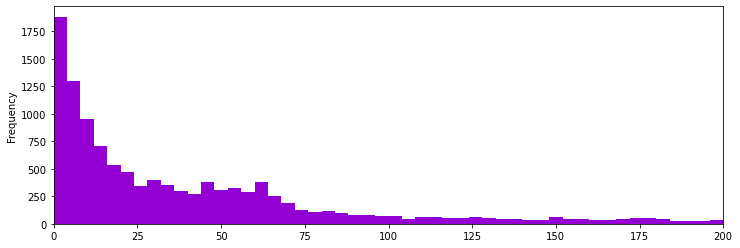

In [189]:
  ''' ВАШ КОД ЗДЕСЬ '''
train_data_10users[train_data_10users['session_timespan'] <= 200].session_timespan.plot.hist(figsize=(12,4), 
                                                                                             bins = 50, 
                                                                                             xlim = (0,200), 
                                                                                             color='darkviolet')

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

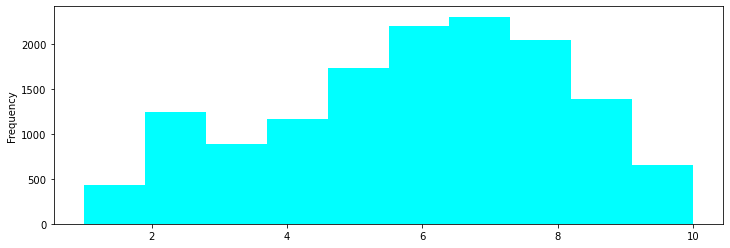

In [190]:
''' ВАШ КОД ЗДЕСЬ '''
train_data_10users['#unique_sites'].plot.hist(figsize=(12,4),
                                              color='aqua')

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

In [184]:
#train_data_10users[['#unique_sites', 'target']].groupby(train_data_10users.target).sum()

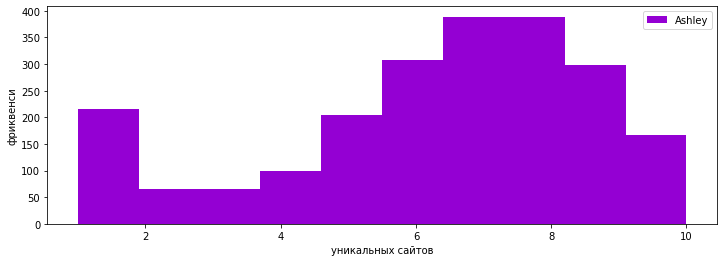

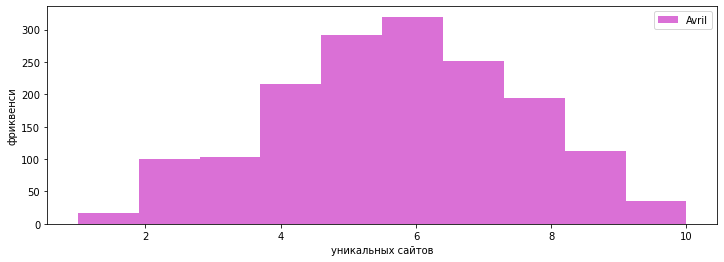

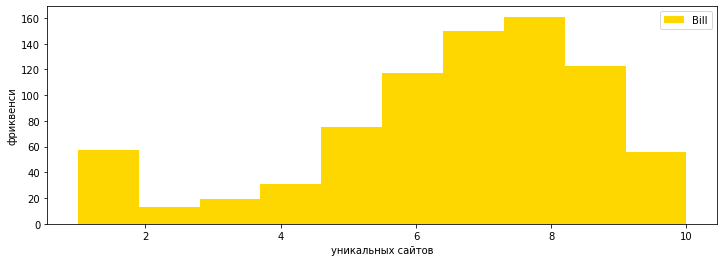

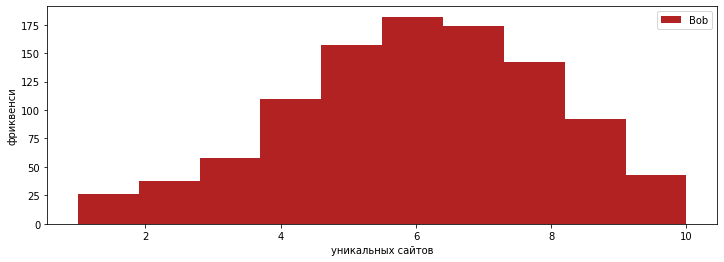

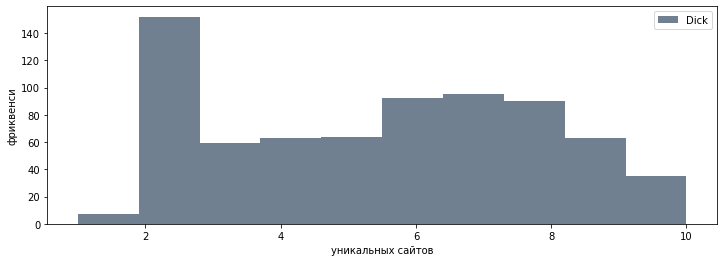

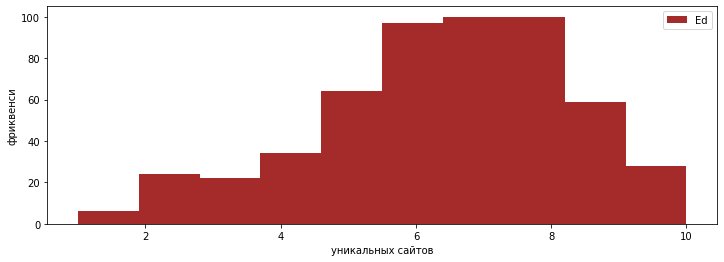

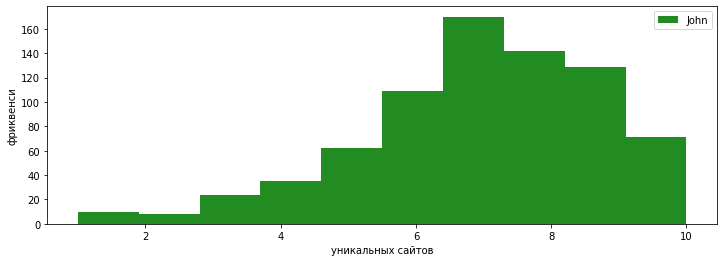

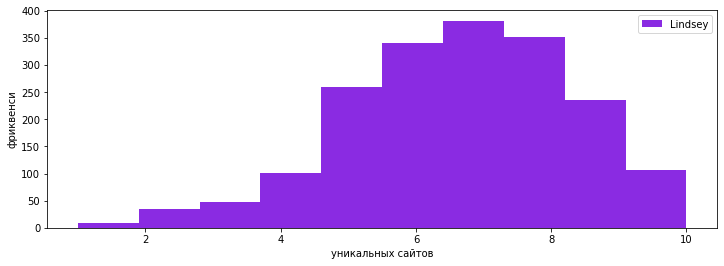

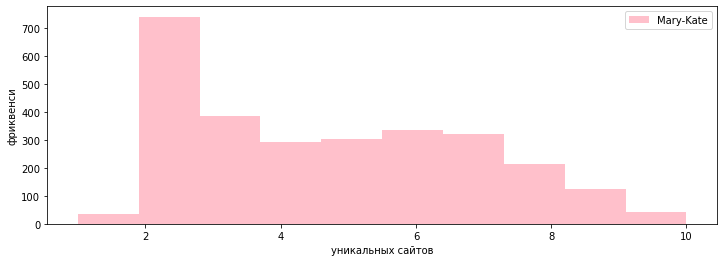

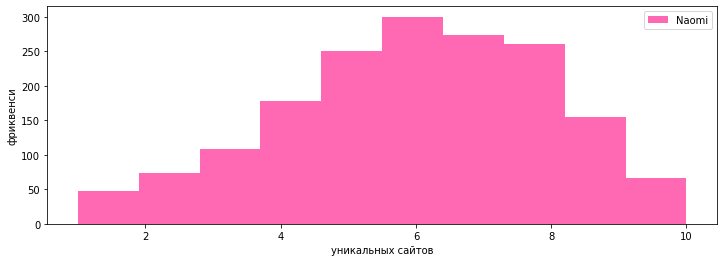

In [237]:
''' ВАШ КОД ЗДЕСЬ '''
# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users[['#unique_sites', 'target']].groupby(train_data_10users.target)): 
    ax = sub_df['#unique_sites'].plot.hist(figsize=(12,4),
                                           color=color_dic[user])
    ax.legend([user])
    ax.set_xlabel('уникальных сайтов')
    ax.set_ylabel('фриквенси')
    plt.show()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

Text(0, 0.5, 'частоты')

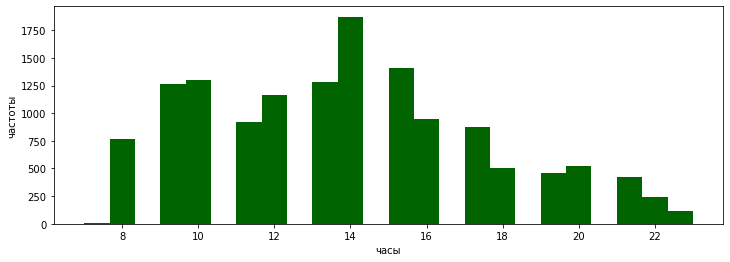

In [245]:
''' ВАШ КОД ЗДЕСЬ '''
plt.figure(figsize = (12, 4))
plt.hist(train_data_10users['start_hour'], bins = 24, color='darkgreen')
plt.xlabel('часы')
plt.ylabel('частоты')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

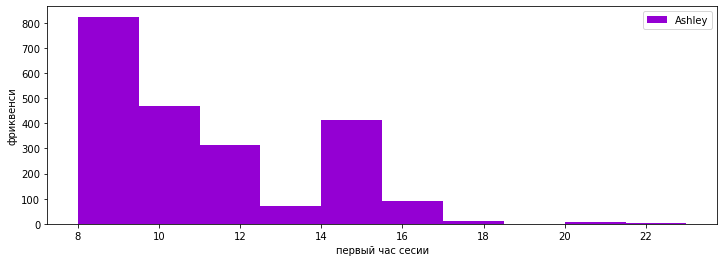

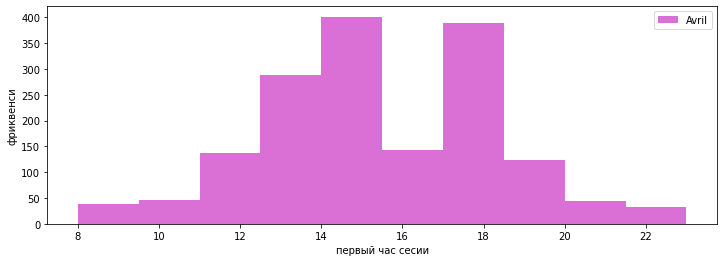

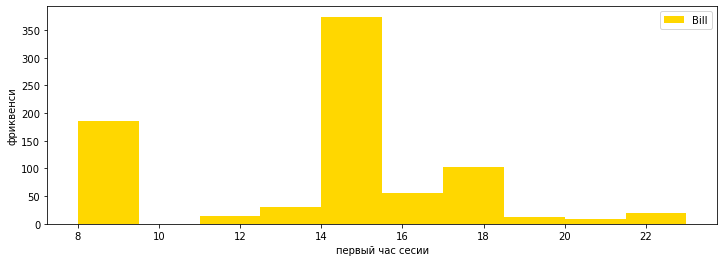

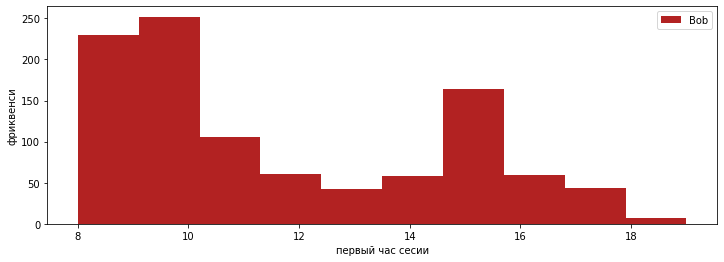

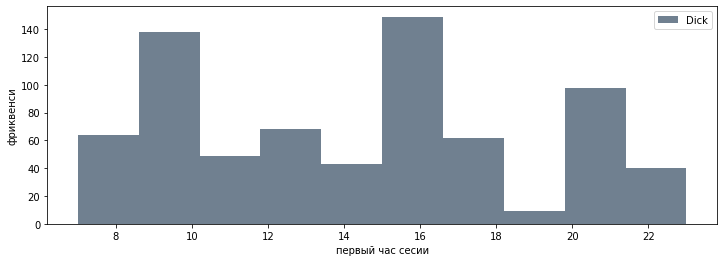

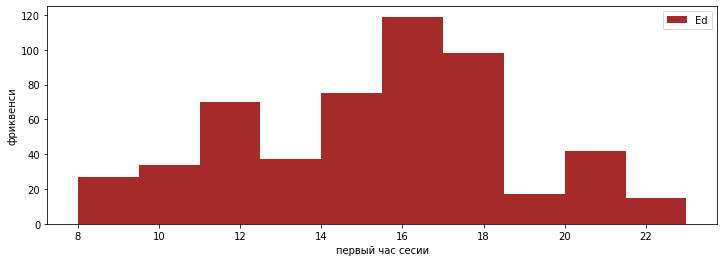

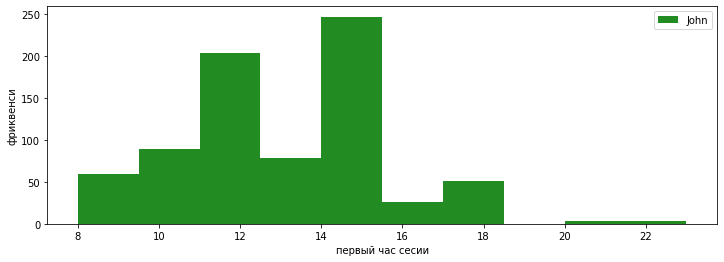

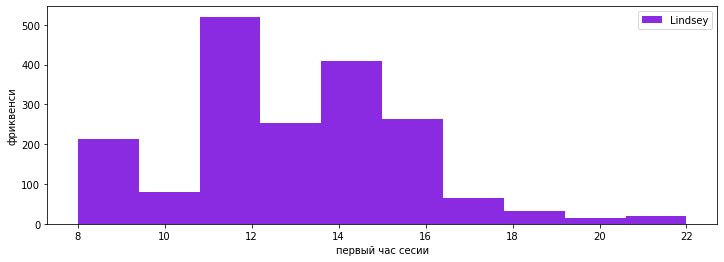

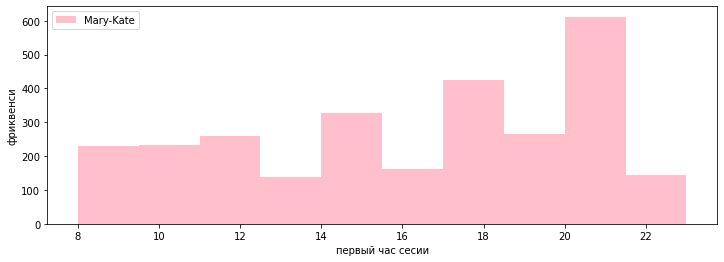

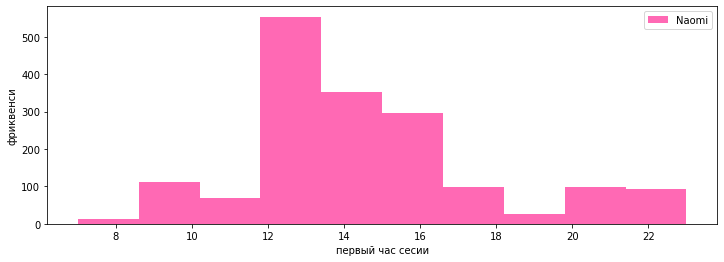

In [247]:
''' ВАШ КОД ЗДЕСЬ '''
for idx, (user, sub_df) in  enumerate(train_data_10users[['start_hour', 'target']].groupby(train_data_10users.target)): 
    ax = sub_df['start_hour'].plot.hist(figsize=(12,4),
                                        color=color_dic[user])
    ax.legend([user])
    ax.set_xlabel('первый час сесии')
    ax.set_ylabel('фриквенси')
    plt.show()
     

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

In [258]:
train_data_10users['day_of_week'].unique()

array([4, 1, 3, 0, 2, 5, 6], dtype=object)

Text(0, 0.5, 'частоты')

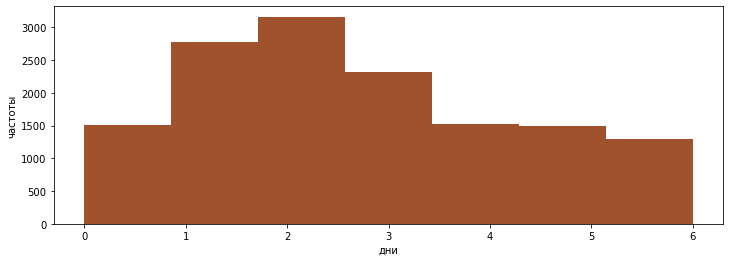

In [252]:
''' ВАШ КОД ЗДЕСЬ '''
plt.figure(figsize = (12, 4))
plt.hist(train_data_10users['day_of_week'], bins = 7, color='sienna')
plt.xlabel('дни')
plt.ylabel('частоты')

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

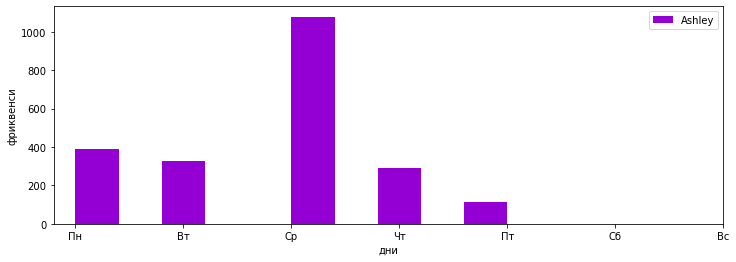

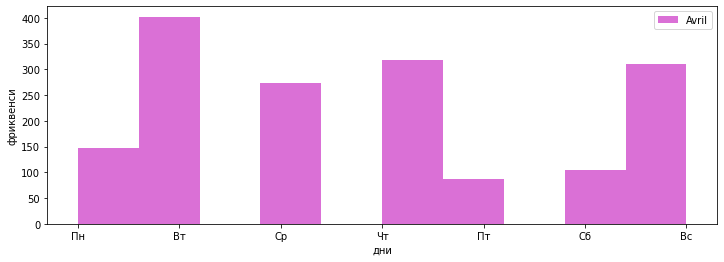

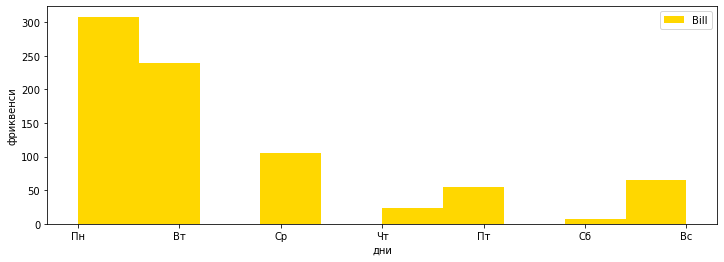

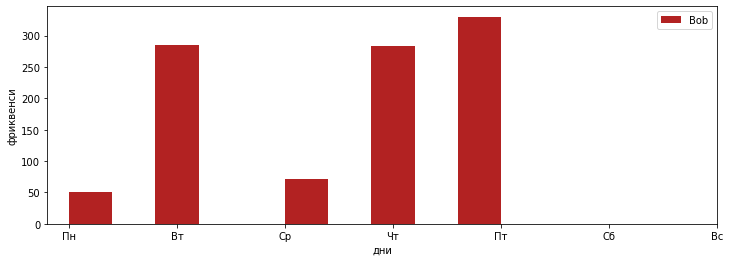

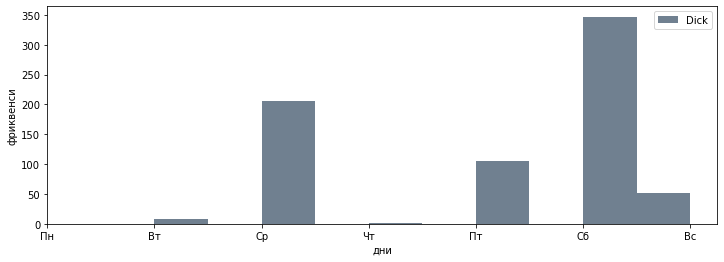

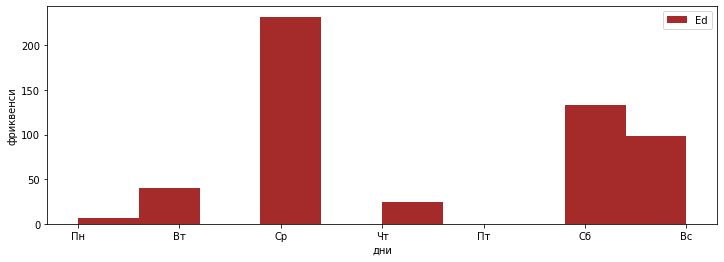

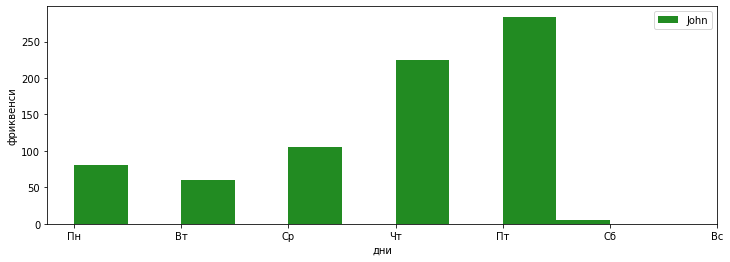

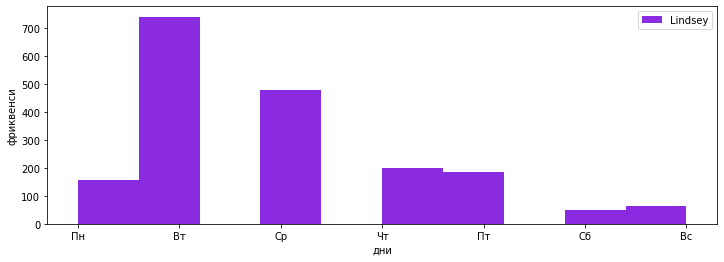

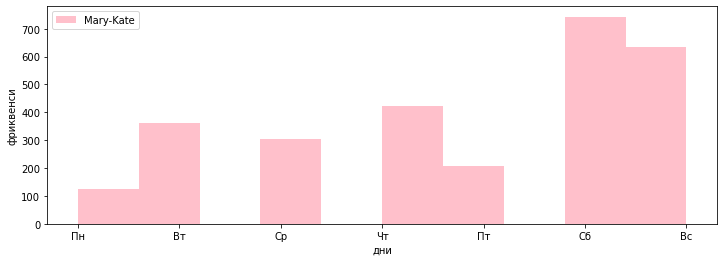

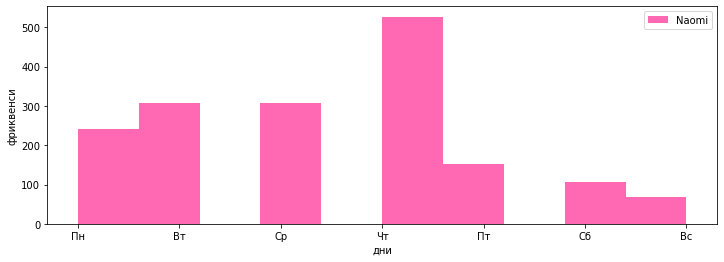

In [261]:
''' ВАШ КОД ЗДЕСЬ '''
for idx, (user, sub_df) in  enumerate(train_data_10users[['day_of_week', 'target']].groupby(train_data_10users.target)): 
    ax = sub_df['day_of_week'].plot.hist(figsize=(12,4),
                                         color=color_dic[user])
    ax.legend([user])
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    ax.set_xlabel('дни')
    ax.set_ylabel('фриквенси')
    plt.show()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Ashley - разные сайты утром в среду<br/>
Avril - несколько сайтов в течение дня всю неделю<br/>
Bill - разные сайты в течение понедельника<br/>
Bob - несколько сайтов по утрам вт, чт и пт<br/>
Dick - пару сайтов в течение выходных<br/>
Ed - разные сайты по вечерам в среду и выходные<br/>
John - разные сайты до обеда с возрастающей интенсивностью с пн по пт, но не в выходные<br/>
Lindsey - разные сайты в течение вторника<br/>
Mary-Kate - пару сайтов по вечерам в выходные<br/>
Naomi - несколько сайтов до обеда всю неделю кроме выходных<br/>

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [264]:
''' ВАШ КОД ЗДЕСЬ '''
with open(os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), 'rb') as site_freq_pkl:
    site_freq_10users = pickle.load(site_freq_pkl)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [282]:
''' ВАШ КОД ЗДЕСЬ '''
top10_freqs = [i[1] for i in list(site_freq_10users.values())[:10]]
top10_sites = list(site_freq_10users.keys())[:10]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

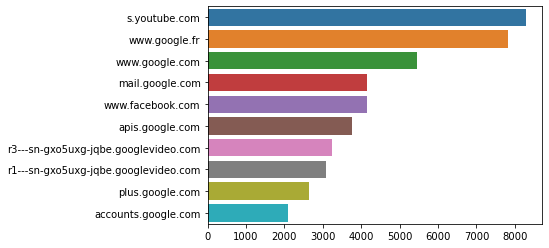

In [290]:
sns.barplot(top10_freqs, top10_sites)

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [139]:
''' ВАШ КОД ЗДЕСЬ ''' 
train_data_10users['session_timespan'].median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [141]:
''' ВАШ КОД ЗДЕСЬ ''' 
train_data_10users['day_of_week'].median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [142]:
''' ВАШ КОД ЗДЕСЬ ''' 
train_data_150users['start_hour'].median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [143]:
''' ВАШ КОД ЗДЕСЬ ''' 
train_data_150users['#unique_sites'].median()

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [298]:
data = pd.DataFrame(columns=['timestamp', 'site', 'id'])
for name in glob(PATH_TO_DATA+'/3users/*.csv'):
    data_1 = pd.read_csv(name, sep=',')
    data_1['id'] = int(''.join([i for i in os.path.basename(name) if i.isdigit()]))   
    data = pd.concat([data, data_1])

data = data.reset_index(drop=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])

with open(os.path.join(PATH_TO_DATA,'site_freq_3users.pkl'), 'rb') as site_freq_pkl:
    site_freq = pickle.load(site_freq_pkl)
    
data_1 = data.copy(deep=True)
users = list(data.id.unique())

for i in range(data.shape[0]):
    if i < data.shape[0] - 1 and data.iloc[i,2] == data.iloc[i+1,2]:
        data_1.iloc[i,0] = int((data.iloc[i+1,0] - data.iloc[i,0]).total_seconds())
    else: data_1.iloc[i,0] = 0
    data_1.iloc[i,1] = site_freq[str(data.iloc[i,1])][0]

data_1['hour'] = data['timestamp'].apply(lambda x: x.hour)
data_1['day'] = data['timestamp'].apply(lambda x: x.dayofweek)    

data_group = data_1[['site', 'id']].groupby(by=['id']).count()

N=10
data_11 = np.asarray(data_1)

gf = np.matrix([0,0,0,0,0])                                            #создаем вспомогательную матрицу

l = list(data_group.index.unique())
for i in l:    
    quantity = int(data_group.loc[i])
    if quantity % N != 0:
        matrix = np.array((N - quantity % N)*[0,0,i,0,0]).reshape(((N - quantity % N),5))
        gf = np.concatenate((gf, data_11[data_11[:,2] == i], matrix))
    else:
        gf = np.concatenate((gf, data_11[data_11[:,2] == i]))
data_11 = np.delete(gf, [0], axis=0)                                  #переназначаем data_11
      
data_time = data_11[:,0].reshape((data_11.shape[0] // N), N)
data_site = data_11[:,1].reshape((data_11.shape[0] // N), N)

session_timing = pd.DataFrame(np.concatenate((data_site,
                                              data_time,
                                              data_11[::N,2],
                                              data_11[::N,3],
                                              data_11[::N,4],
                                              data_11[::N,2]),
                                             axis=1))

session_timing.iloc[:,19] = session_timing.iloc[:, 10:19].sum(axis=1).astype(int)
session_timing.iloc[:,20] = session_timing.iloc[:, 0:10].apply(lambda x: len(set(filter(lambda a: a != 0, x))), axis=1)

feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']

session_timing.columns = feature_names
session_timing
#pd.DataFrame(data_11, columns=['timestamp', 'site', 'id', 'hour', 'wday'])

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,11,2,1,9,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,5,5,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,6,10,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


In [300]:
site_freq
top10_freqs = [i[1] for i in list(site_freq.values())[:10]]
top10_sites = list(site_freq.keys())[:10]
top10_sites

['google.com',
 'oracle.com',
 'vk.com',
 'meduza.io',
 'football.kulichki.ru',
 'mail.google.com',
 'apis.google.com',
 'plus.google.com',
 'accounts.google.com',
 'yandex.ru']

In [ ]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    ''' 

In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 